<a href="https://colab.research.google.com/github/pbpbpb2705/GANUsingPytorch/blob/main/GAN_using_PyTorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

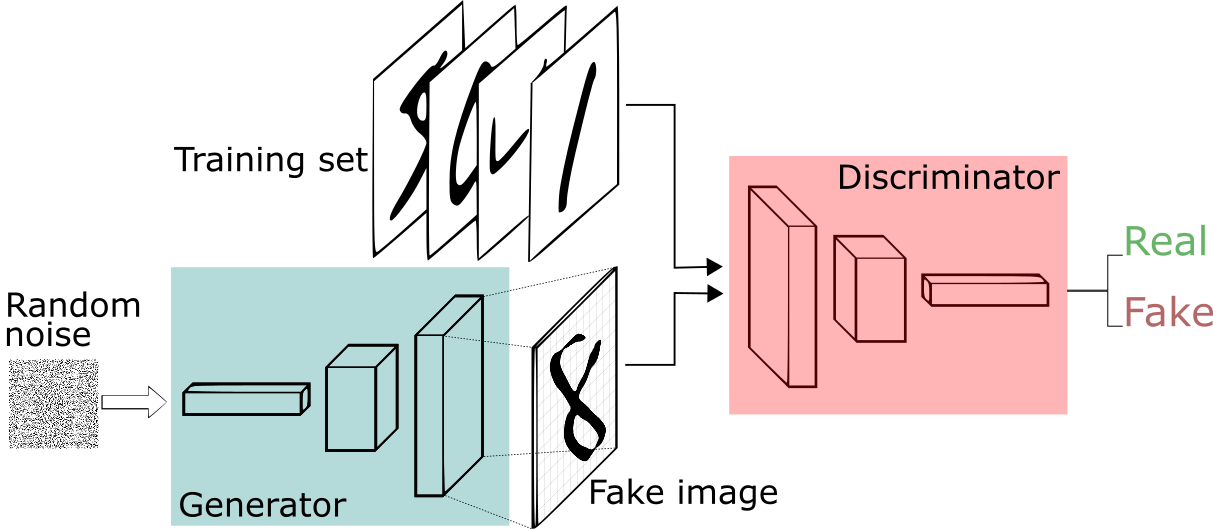

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'

#Batch size for train loader
batch_size = 128
epochs = 20
noise_dimension = 64

#Optimizer parameter: learning rate, beta1, beta2
lr = 2e-4
beta_1 = 0.5
beta_2 = 0.99




# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augmentations = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor(), #(h, w, c) => (c, h, w)
    T.Normalize((0.5,), (0.5,))
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augmentations)

100%|██████████| 9912422/9912422 [00:00<00:00, 51364056.83it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115919324.23it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76160333.42it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23232352.16it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



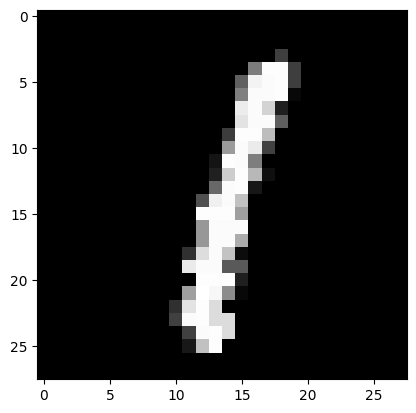

In [ ]:
image, label = trainset[3]

plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(train_loader)

images, _ = dataiter.__next__()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

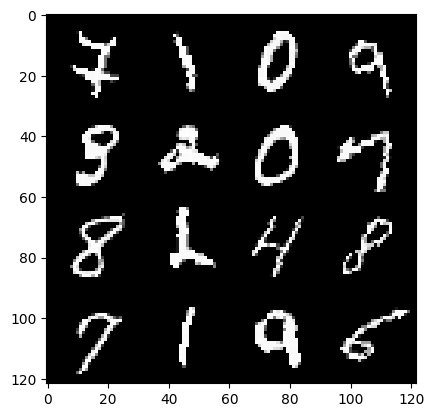

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
#Get discriminator block
def get_disc_block(input_channels, output_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      nn.BatchNorm2d(output_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    #Follow the above structure
    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5) , 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, images):

    #Follow the above structure
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
def get_gen_block(input_channels, output_channels, kernel_size, stride, final_block = False):
  if (final_block):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh()
    )
  else:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
class Generator(nn.Module):

  def __init__(self, noice_dimension):
    super(Generator, self).__init__()
    self.noise_dimension = noise_dimension

    #Follow the structure above
    self.block_1 = get_gen_block(noise_dimension, 256, (3, 3), 1)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2)

    self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block = True)

  def forward(self, noise):
    #Modify dimension
    x = noise.view(-1, self.noise_dimension, 1, 1)
    #Follow the structure above
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noise_dimension)
G.to(device)

summary(G, input_size=(noise_dimension, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  gronud_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, gronud_truth)
  return loss

In [ ]:
D_opt = torch.optim.AdamW(D.parameters(), lr = lr, betas = (0.5, 0.999))
G_opt = torch.optim.AdamW(G.parameters(), lr = lr, betas = (0.5, 0.999))

# Training Loop

In [ ]:
def train_function(num_epochs):
  for i in range(num_epochs):
    d_loss = 0.0
    g_loss = 0.0

    for real_images, _ in train_loader:
      real_images = real_images.to(device)
      noise = torch.randn(batch_size, noise_dimension, device = device)

      D_opt.zero_grad()

      fake_images = G(noise)
      D_pred = D(fake_images)
      D_fake_loss = fake_loss(D_pred)

      D_pred = D(real_images)
      D_real_loss = real_loss(D_pred)

      D_loss = (D_fake_loss + D_real_loss) / 2
      d_loss += D_loss.item()
      D_loss.backward()
      D_opt.step()

      G_opt.zero_grad()

      noise = torch.randn(batch_size, noise_dimension, device = device)
      fake_images = G(noise)
      D_pred = D(fake_images)
      G_loss = real_loss(D_pred)
      g_loss += G_loss.item()

      G_loss.backward()
      G_opt.step()

    avg_d_loss = d_loss / len(train_loader)
    avg_g_loss = g_loss / len(train_loader)
    print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

train_function(epochs)


Epoch : 1 | D_loss : 0.6663827078937213 | G_loss : 0.7120573678250506
Epoch : 2 | D_loss : 0.6766251667476157 | G_loss : 0.7139024644264026
Epoch : 3 | D_loss : 0.6673182064790462 | G_loss : 0.7306359276842715
Epoch : 4 | D_loss : 0.6498728929552188 | G_loss : 0.7550350214118389
Epoch : 5 | D_loss : 0.626549494800283 | G_loss : 0.7939100505700752
Epoch : 6 | D_loss : 0.6082539713458974 | G_loss : 0.8297769021886244
Epoch : 7 | D_loss : 0.5946078037402269 | G_loss : 0.8604158390559622
Epoch : 8 | D_loss : 0.5874185291434656 | G_loss : 0.8840448543715325
Epoch : 9 | D_loss : 0.5834474564869521 | G_loss : 0.9000273632850728
Epoch : 10 | D_loss : 0.5780719920262091 | G_loss : 0.9223394862878551
Epoch : 11 | D_loss : 0.577018115057874 | G_loss : 0.9283399363316452
Epoch : 12 | D_loss : 0.5752886104177056 | G_loss : 0.9432568557735191
Epoch : 13 | D_loss : 0.5729595215590015 | G_loss : 0.9515017926820052
Epoch : 14 | D_loss : 0.5667092309577633 | G_loss : 0.9687579523271589
Epoch : 15 | D_lo

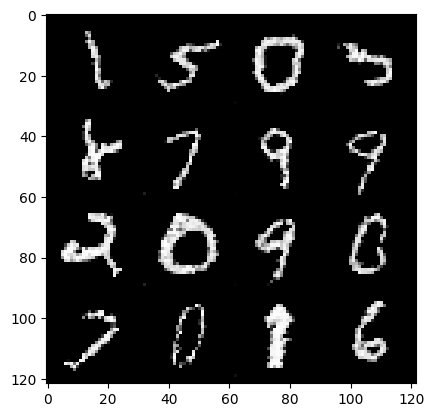

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dimension, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya